# Waste Classification Model

**Data source:** https://www.kaggle.com/techsash/waste-classification-data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dependencies

import pandas as pd
import numpy as np
import logging
import tensorflow as tf
import warnings
import glob
import tqdm
import os

from tqdm import tqdm 
from IPython import display 
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten # convolution layers & core layers

from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

## Data Structure
Data source: https://www.kaggle.com/techsash/waste-classification-data

In [ ]:
# Directory paths for importing data

base_dir = "/content/drive/MyDrive/Internships/AI_Medical_Imaging/Microscopic_Images_Internship/Breast_Cancer/Datasets/BreaKHis_v1/histology_slides/breast"
# train_dir = "/content/drive/MyDrive/Internships/AI_Medical_Imaging/Microscopic_Images_Internship/Breast_Cancer/Datasets/ICIAR2018_BACH_Challenge/Photos"
# test_dir = "/content/drive/MyDrive/Internships/AI_Medical_Imaging/Microscopic_Images_Internship/Breast_Cancer/Datasets/ICIAR2018_BACH_Challenge_TestDataset/Photos"

## Data Augmentation

In [ ]:
train = ImageDataGenerator(validation_split=0.2)

## Train dataset

In [ ]:
# Train dataset

train_ds  = train.flow_from_directory(directory = base_dir,
                                                   target_size = (150, 150),
                                                   class_mode = 'binary',
                                                   batch_size = 64, 
                                                   subset = 'training')

Found 6328 images belonging to 2 classes.


## Validate dataset

In [ ]:
# Validate dataset

valid_ds = train.flow_from_directory(directory = base_dir,
                                                  target_size = (150, 150),
                                                  class_mode = 'binary',
                                                  batch_size = 64, 
                                                  subset = 'validation')

Found 1581 images belonging to 2 classes.


In [ ]:
# Check classes

print(train_ds.class_indices)

{'benign': 0, 'malignant': 1}


# Building The Model

In [ ]:
# Defining callbacks

filepath = '/content/drive/MyDrive/Internships/AI_Medical_Imaging/Microscopic_Images_Internship/Breast_Cancer/Datasets/BreaKHis_v1/histology_slides/model_weights_vgg/breastCancer_{epoch:02d}-{val_accuracy:.6f}.h5'

earlystopping = EarlyStopping(monitor = 'accuracy',  
                              patience = 5,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'accuracy', 
                                mode='min', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

## Base Model (VGG16)

In [ ]:
# Base model

base_model = VGG16(input_shape=(150,150,3), 
                   include_top=False,
                   weights="imagenet")

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freezing layers 

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Show vgg model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Visualizing Base Model Layers With Test Images

block1_conv1
64


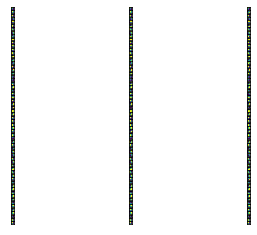

block1_conv2
64


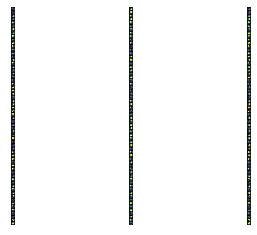

block2_conv1
128


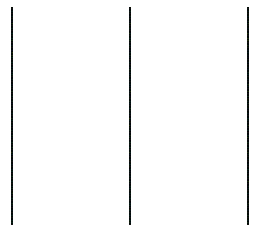

block2_conv2
128


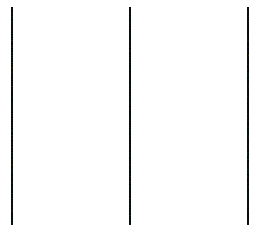

block3_conv1
256


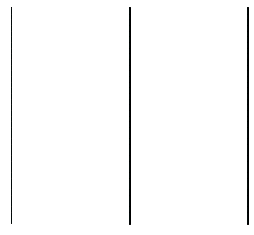

block3_conv2
256


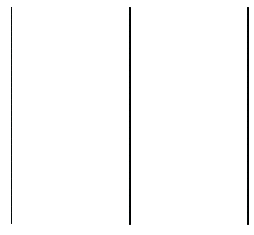

block3_conv3
256


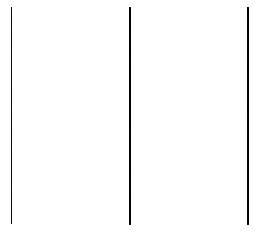

block4_conv1
512


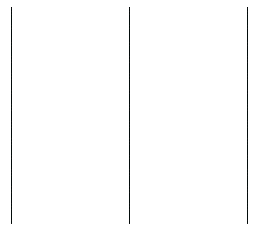

block4_conv2
512


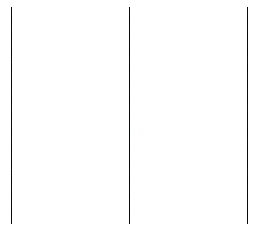

block4_conv3
512


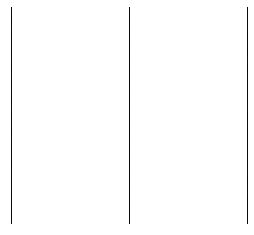

block5_conv1
512


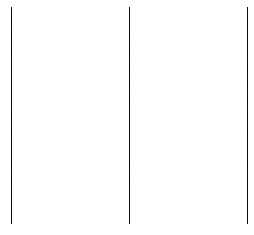

block5_conv2
512


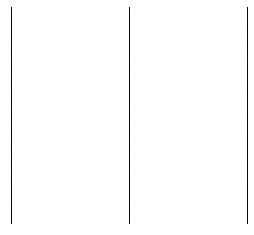

block5_conv3
512


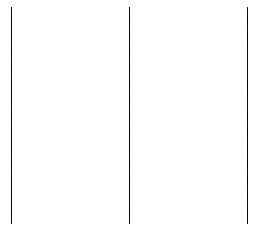

In [ ]:
# Iterate thru all the layers of the model

for layer in base_model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        # filters, biases = layer.get_weights()
        print(layer.name)
        # print(layer.name, filters.shape)
        # normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        # plotting all the filters
        for i in range(filters.shape[3]):
            # get the filters
            filt=filters[:,:,:, i]
            # plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

(1, 180, 180, 64)
(1, 180, 180, 64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


(1, 90, 90, 64)
(1, 90, 90, 128)
(1, 90, 90, 128)
(1, 45, 45, 128)
(1, 45, 45, 256)
(1, 45, 45, 256)
(1, 45, 45, 256)
(1, 22, 22, 256)
(1, 22, 22, 512)
(1, 22, 22, 512)
(1, 22, 22, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 5, 5, 512)


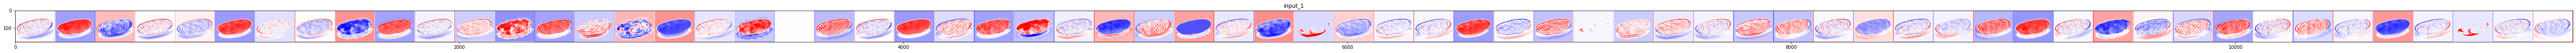

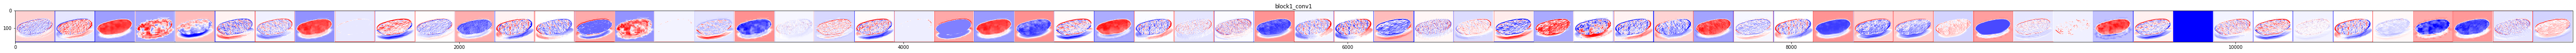

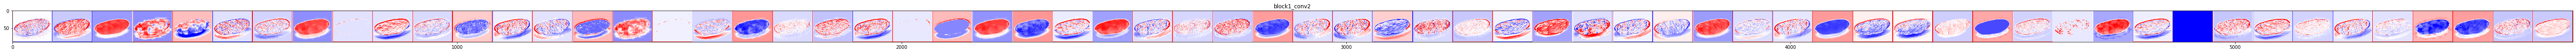

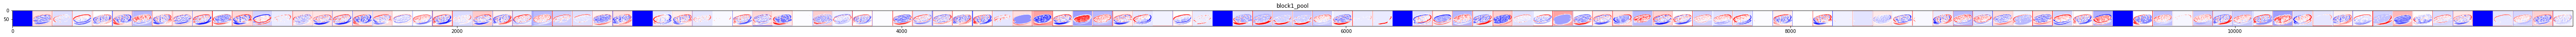

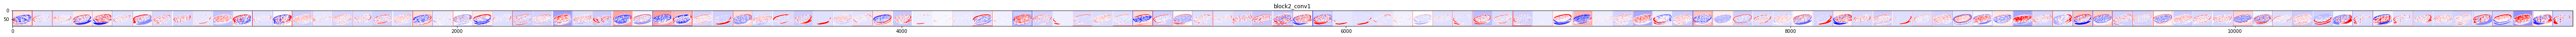

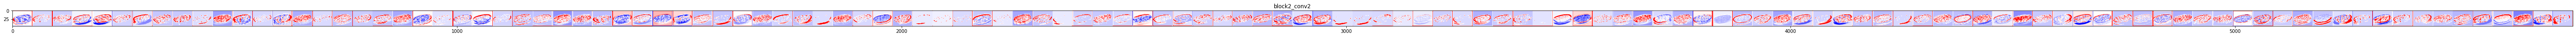

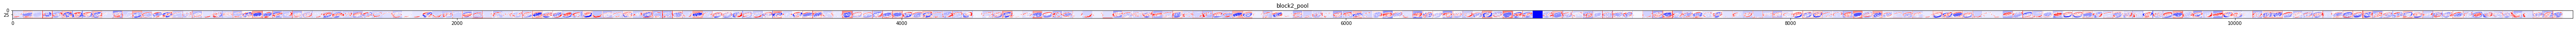

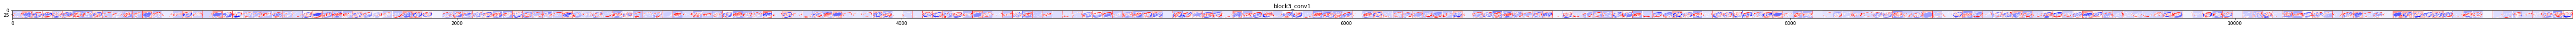

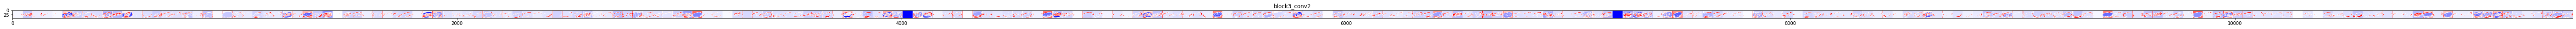

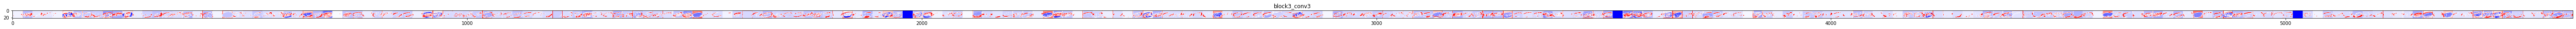

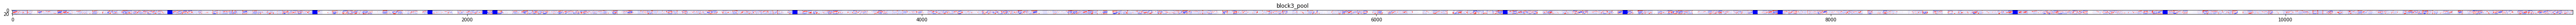

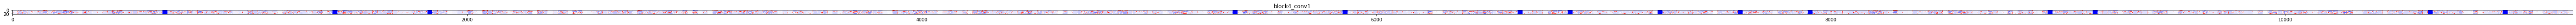

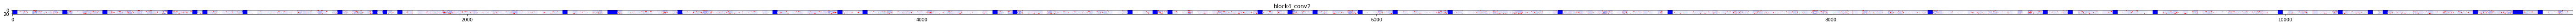

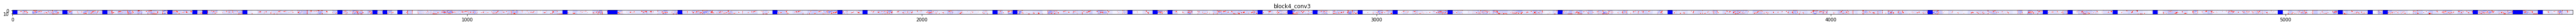

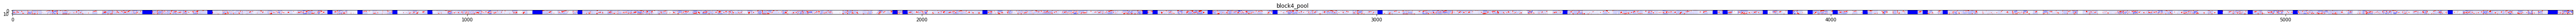

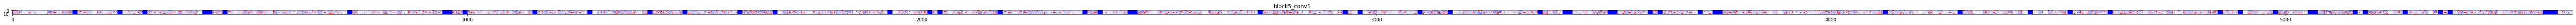

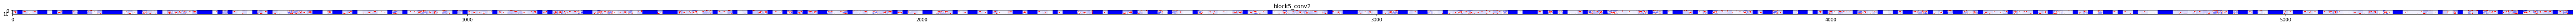

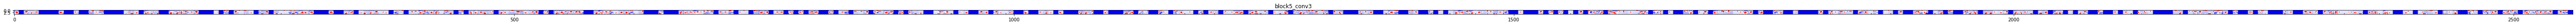

In [ ]:
# Visualize feature maps for an organic image

# Image path
img_path=test_dir + '/O' + '/O_12825.jpg'

# Define a new model, input=image 
# Output=intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in base_model.layers[1:]]

# Visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = base_model.input, outputs = successive_outputs)

# Load the input image
img = load_img(img_path, target_size=(180, 180))

# Convert ht image to Array of dimension (180,180,3)
x = img_to_array(img)                           
x = x.reshape((1,) + x.shape)

# Rescale by 1/255
x /= 255.0

# Run input image through our visualization network to obtain all intermediate representations for the image
successive_feature_maps = visualization_model.predict(x)

# Retrieve the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in base_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile our images in a matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
        
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
        
# Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features*5, scale*4))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='bwr' )

# Disable tf warning
logging.getLogger('tensorflow').disabled = True

(1, 180, 180, 64)
(1, 180, 180, 64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


(1, 90, 90, 64)
(1, 90, 90, 128)
(1, 90, 90, 128)
(1, 45, 45, 128)
(1, 45, 45, 256)
(1, 45, 45, 256)
(1, 45, 45, 256)
(1, 22, 22, 256)
(1, 22, 22, 512)
(1, 22, 22, 512)
(1, 22, 22, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 5, 5, 512)


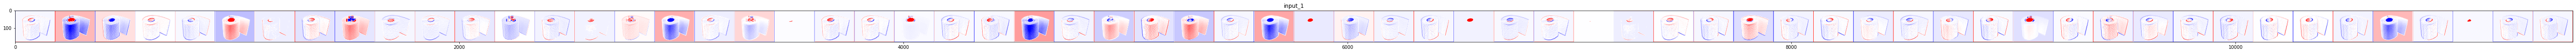

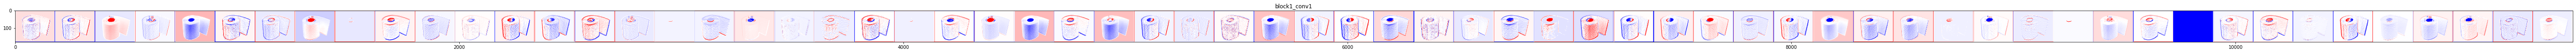

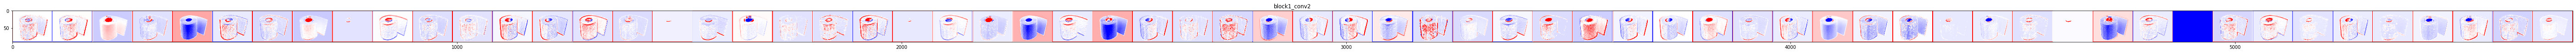

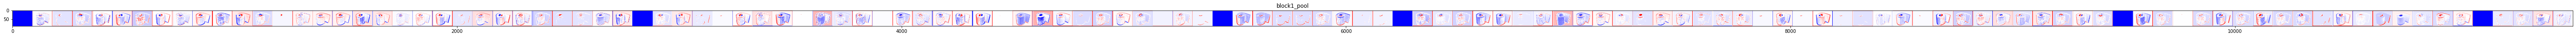

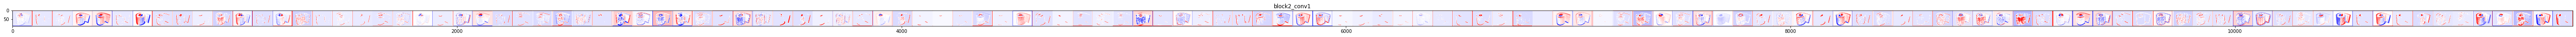

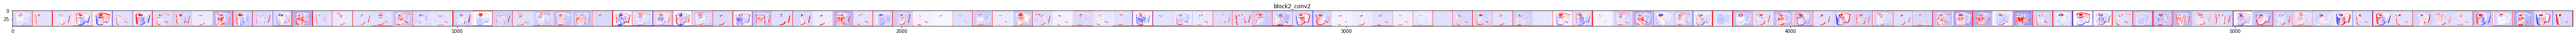

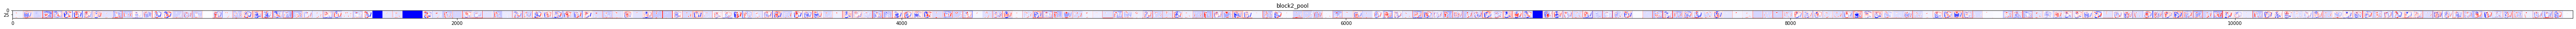

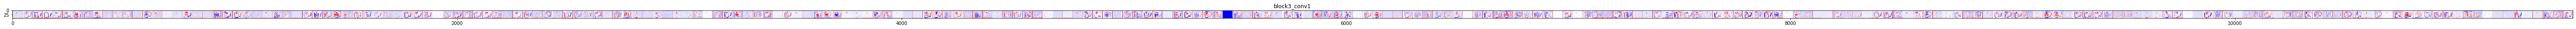

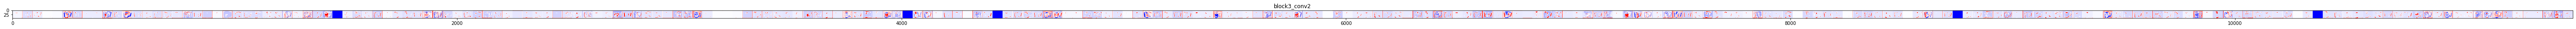

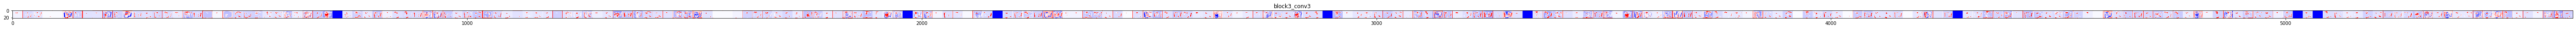

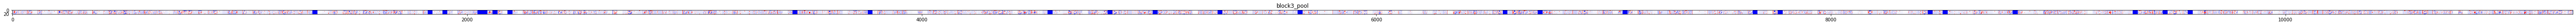

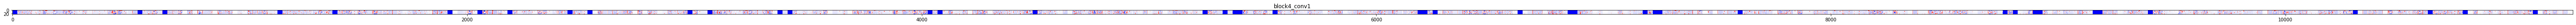

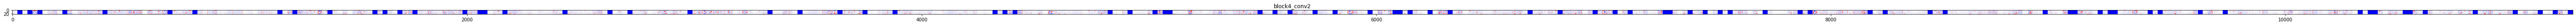

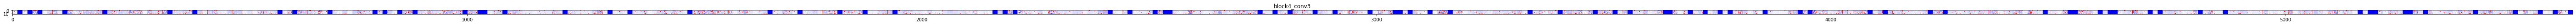

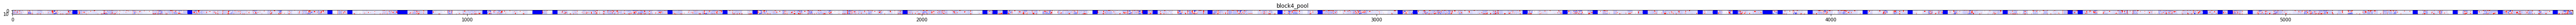

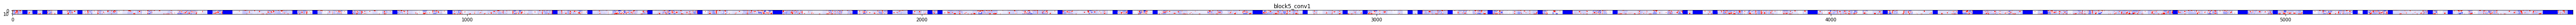

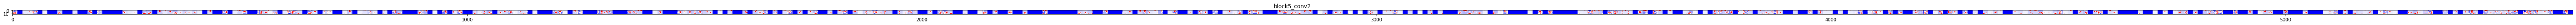

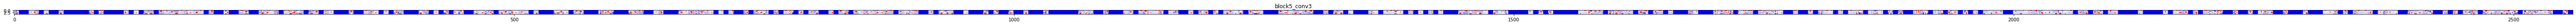

In [ ]:
# Visualize feature maps for a recycled image

# Image path
img_path=test_dir + '/R' + '/R_11107.jpg'

# Define a new model, input=image 
# Output=intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in base_model.layers[1:]]

# Visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = base_model.input, outputs = successive_outputs)

# Load the input image
img = load_img(img_path, target_size=(180, 180))

# Convert ht image to Array of dimension (180,180,3)
x = img_to_array(img)                           
x = x.reshape((1,) + x.shape)

# Rescale by 1/255
x /= 255.0

# Run input image through our visualization network to obtain all intermediate representations for the image
successive_feature_maps = visualization_model.predict(x)

# Retrieve the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in base_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
        
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
        
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features*5, scale*4) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='bwr' )

# Ignore Runtimewarning
warnings.filterwarnings('ignore')

## Adding to the Base Model -  Building Dense Layers

In [ ]:
# Defining Layers
model=Sequential()
model.add(base_model) 
model.add(Dropout(0.2))
model.add(Flatten())

# Add dense layers
model.add(BatchNormalization())
model.add(Dense(5000,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1000,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(500,activation="relu",kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
# Show model summary (with custom layers)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 5000)              40965000  
                                                                 
 batch_normalization_1 (Batc  (None, 5000)             20000     
 hNormalization)                                        

## Model Training

In [ ]:
# Model fit (training)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_history = model.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks = callback_list, verbose = 1)

Epoch 1/10
99/99 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.8037 
Epoch 00001: accuracy improved from inf to 0.80373, saving model to /content/drive/MyDrive/Internships/AI_Medical_Imaging/Microscopic_Images_Internship/Breast_Cancer/Datasets/BreaKHis_v1/histology_slides/model_weights_vgg/breastCancer_01-0.622391.h5
99/99 [==============================] - 2325s 23s/step - loss: 0.5962 - accuracy: 0.8037 - val_loss: 2.6148 - val_accuracy: 0.6224
Epoch 2/10
99/99 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.9120
Epoch 00002: accuracy did not improve from 0.80373
99/99 [==============================] - 171s 2s/step - loss: 0.2439 - accuracy: 0.9120 - val_loss: 1.2426 - val_accuracy: 0.7059
Epoch 3/10
99/99 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9535
Epoch 00003: accuracy did not improve from 0.80373
99/99 [==============================] - 154s 2s/step - loss: 0.1284 - accuracy: 0.9535 - val_loss: 1.3

In [ ]:
from keras.models import load_model

model.save('/content/drive/MyDrive/Internships/AI_Medical_Imaging/Microscopic_Images_Internship/Breast_Cancer/Datasets/BreaKHis_v1/histology_slides/model_weights_vgg/final_weights.h5')

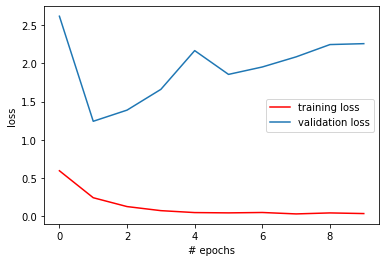

In [ ]:
plt.plot(model_history.history['loss'],'r',label='training loss')
plt.plot(model_history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

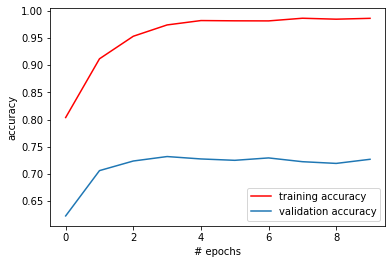

In [ ]:
plt.plot(model_history.history['accuracy'],'r',label='training accuracy')
plt.plot(model_history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Model Evaluation

In [ ]:
# Evaluate overall loss and accuracy for test data
model.evaluate(test_ds)

RuntimeError: ignored

In [ ]:
# Store final values as variables

loss_final = 0.3716025650501251
auc_final =  0.9337255358695984
print(f"The final loss was {loss_final}, and the final accuracy was {auc_final}.")

The final loss was 0.3716025650501251, and the final accuracy was 0.9337255358695984.


## Classification Report

In [ ]:
# Confusion Matrix and Classification Report

metrics=tf.keras.metrics.AUC(name = 'auc')

num_of_test_samples = 2513
batch_size = 32

Y_pred = model.predict(test_ds, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))
print('Classification Report')
target_names = ['Organic', 'Recycled']
print(classification_report(test_ds.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1295  106]
 [ 215  897]]
Classification Report
              precision    recall  f1-score   support

     Organic       0.86      0.92      0.89      1401
    Recycled       0.89      0.81      0.85      1112

    accuracy                           0.87      2513
   macro avg       0.88      0.87      0.87      2513
weighted avg       0.87      0.87      0.87      2513



Text(0.5, 1.0, 'Classification Report')

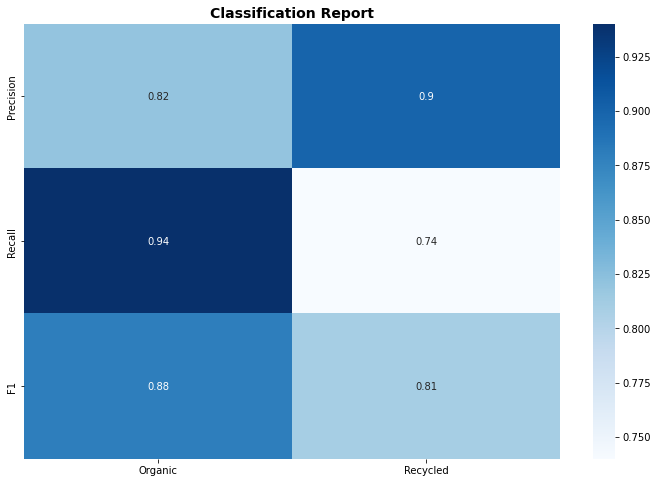

In [ ]:
# Plot the classification report

# Put data into a 2D array
data = np.array([[.82, .90],
                 [.94, .74],
                [.88, .81]])

# Plot the heatmap
yticklabels = ['Precision', 'Recall', 'F1']
xticklabels = ['Organic', 'Recycled']
fig, ax = plt.subplots(figsize=(12,8)) 
ax = sns.heatmap(data, xticklabels=xticklabels, yticklabels=yticklabels, annot=True, cmap='Blues')
ax.set_title("Classification Report", fontsize=14, fontweight='bold')

## True & False Positives

In [ ]:
# Removing scientific notation in the heatmap

np.set_printoptions(suppress=True, threshold=2000)

## Predicting Test Images

In [ ]:
# Load the saved model weights

model = load_model('/content/final_model_weights.hdf5')

In [ ]:
def getprediction(img):
    img = img_to_array(img)
    img = img / 255
    imshow(img)
    plt.axis('off')
    img = np.expand_dims(img,axis=0)
    category = model.predict(img)
    answer = category[0]
    probability = model.predict(img)
    probability_results = probability[0][0]
    if answer[1] > answer[0]:
        print(f"The image belongs to Recycle waste category, probability: {probability[0][1]}.")
    else:
        print(f"The image belongs to Organic waste category, probability: {probability[0][0]}.")

The image belongs to Organic waste category, probability: 0.999984622001648.


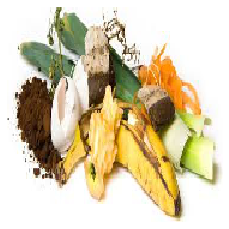

In [ ]:
# Test Case 1 - ORGANIC

test_case1 = load_img('/content/drive/MyDrive/Waste_Classification/O_T.jpg', target_size=(180,180))
getprediction(test_case1)

The image belongs to Recycle waste category, probability: 0.984473466873169.


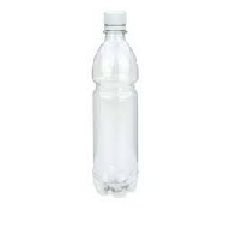

In [ ]:
# Test Case 2 - ORGANIC

test_case2 = load_img('/content/drive/MyDrive/Waste_Classification/R_T.jpg', target_size=(180,180))
getprediction(test_case2)

The image belongs to Organic waste category, probability: 0.8949116468429565.


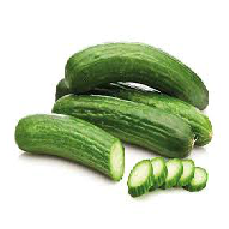

In [ ]:
# Test Case 3 - ORGANIC

test_case3 = load_img(test_dir + '/O' + '/O_13905.jpg', target_size=(180,180))
getprediction(test_case3)

The image belongs to Recycle waste category, probability: 0.930503785610199.


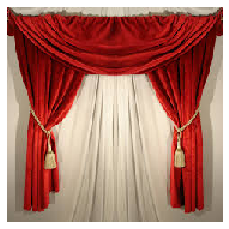

In [ ]:
# Test Case 4 - RECYCLED

test_case4 = load_img(test_dir + '/R' + '/R_10000.jpg', target_size=(180,180))
getprediction(test_case4)

The image belongs to Organic waste category, probability: 0.5654208660125732.


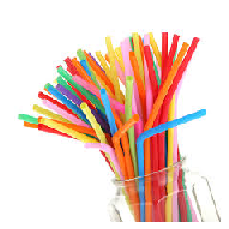

In [ ]:
# Test Case 5 - RECYCLED

test_case5 = load_img(test_dir + '/R' + '/R_10398.jpg', target_size=(180,180))
getprediction(test_case5)

The image belongs to Recycle waste category, probability: 0.7832229137420654.


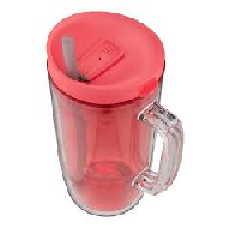

In [ ]:
# Test Case 6 - RECYCLED
test_case6 = load_img(test_dir + '/R' + '/R_10714.jpg', target_size=(180,180))
getprediction(test_case6)

The image belongs to Recycle waste category, probability: 0.8447807431221008.


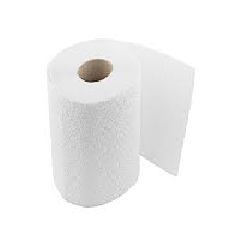

In [ ]:
# Test Case 7 - RECYCLED
test_case7 = load_img(test_dir + '/R' + '/R_11107.jpg', target_size=(180,180))
getprediction(test_case7)

The image belongs to Organic waste category, probability: 0.6308489441871643.


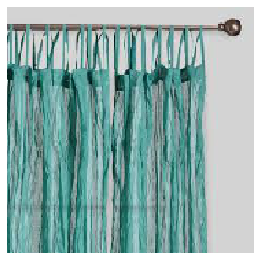

In [ ]:
# Test Case 8 - RECYCLED
test_case8 = load_img(test_dir + '/R' + '/R_10005.jpg', target_size=(180,180))
getprediction(test_case8)

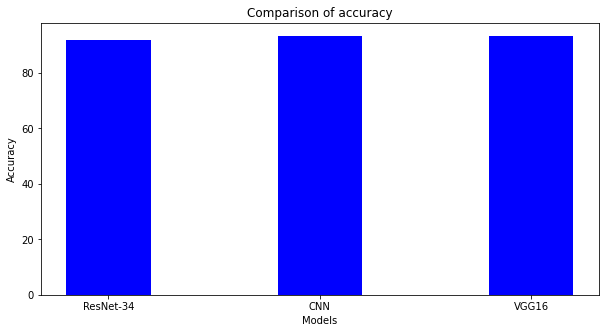

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'ResNet-34':91.8, 'CNN':93.356, 'VGG16':93.372}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of accuracy")
plt.show()

In [ ]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name, price)